In [1]:
import networkx as nx

In [2]:
G = nx.Graph()

In [3]:
G.graph['key'] = 'value'

In [4]:
G.add_node(0, feature='feature', label=0)

In [5]:
G.add_nodes_from([
  (1, {"feature": 1, "label": 1}),
  (2, {"feature": 2, "label": 2})
])

In [6]:
G.add_edge(0, 1, weight=0.5)

In [7]:
G.edges[(0, 1)]

{'weight': 0.5}

In [8]:
G.add_edges_from([
  (1, 2, {"weight": 0.3}),
  (2, 0, {"weight": 0.1})
])

In [9]:
G.nodes, G.edges

(NodeView((0, 1, 2)), EdgeView([(0, 1), (0, 2), (1, 2)]))

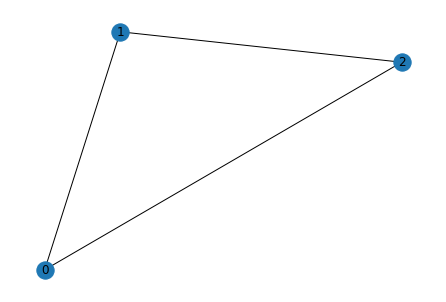

In [10]:
nx.draw(G, with_labels = True)

In [11]:
G.add_node(3)

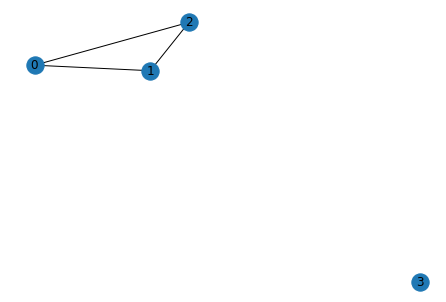

In [12]:
nx.draw(G, with_labels = True)

In [13]:
G.add_edge(3, 1, weight=0.6)

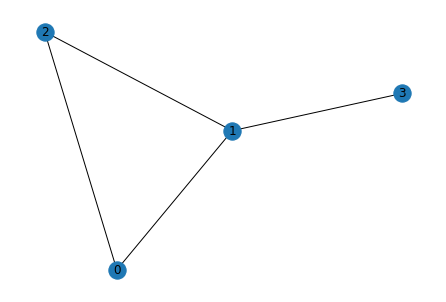

In [14]:
nx.draw(G, with_labels = True)

In [15]:
G.degree[1]

3

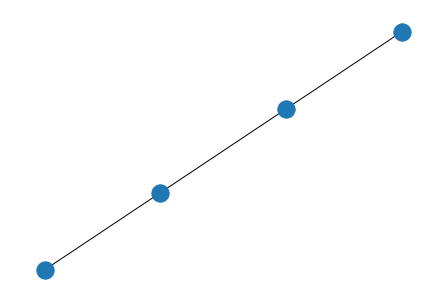

In [16]:
nx.draw(nx.path_graph(4))

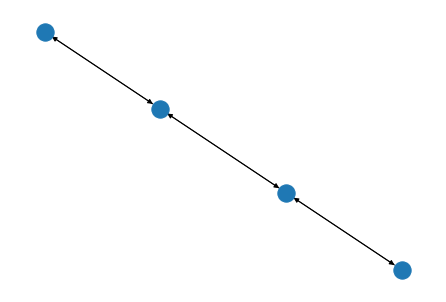

In [17]:
G = nx.DiGraph(nx.path_graph(4))
nx.draw(G)

In [18]:
pr = nx.pagerank(G, alpha=1)
pr

{0: 0.16666698455810547,
 1: 0.33333301544189453,
 2: 0.33333301544189453,
 3: 0.16666698455810547}

In [19]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [20]:
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [21]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

/Users/vinay/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [27]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 9.18
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


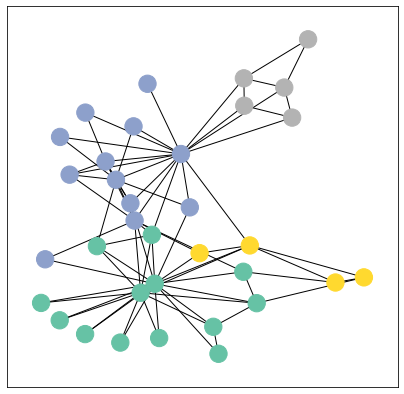

In [29]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

In [72]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_layers=3, input_dim=34, hidden_dim=6, output_dim=2):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.classifier = Linear(output_dim, dataset.num_classes)

        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        for l in range(num_layers-1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))

        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index, num_layers=3):

        for l in range(num_layers):
            x = self.convs[l](x, edge_index)
            x = x.tanh()
    
        #h = self.relu(h)
        h = torch.nn.functional.relu(x)
        h = torch.nn.functional.dropout(h, p=0.5, training=self.training)
        h = self.convs[-1](h, edge_index)
        embeddings = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(embeddings)

        return out, embeddings

model = GCN()
model

GCN(
  (classifier): Linear(in_features=2, out_features=4, bias=True)
  (convs): ModuleList(
    (0): GCNConv(34, 6)
    (1): GCNConv(6, 6)
    (2): GCNConv(6, 6)
    (3): GCNConv(6, 2)
  )
  (relu): ReLU()
)

Embedding shape: [34, 2]


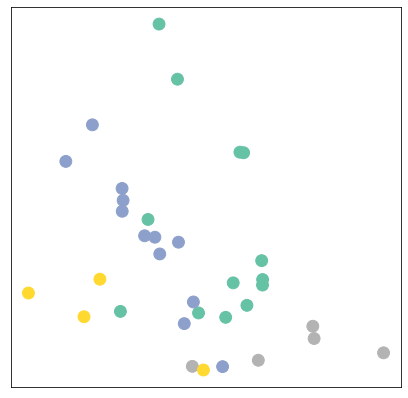

In [73]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

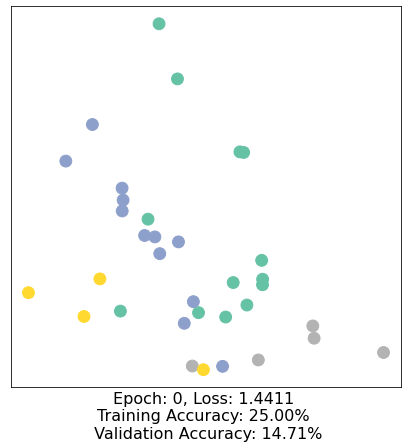

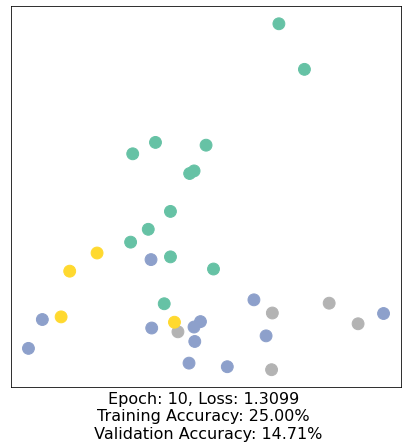

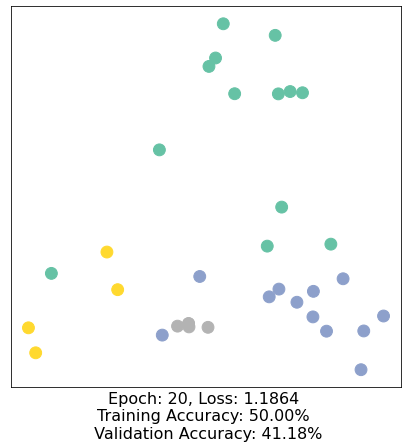

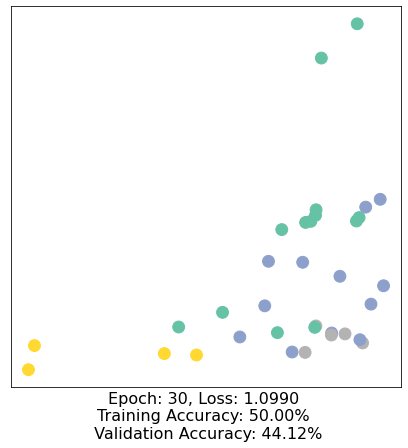

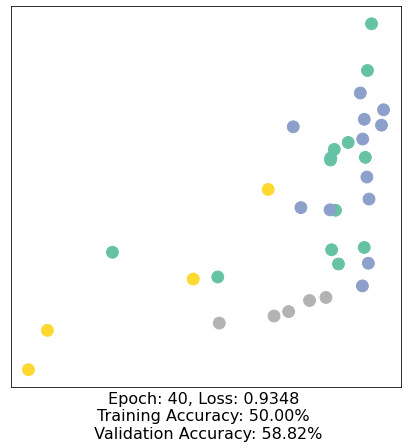

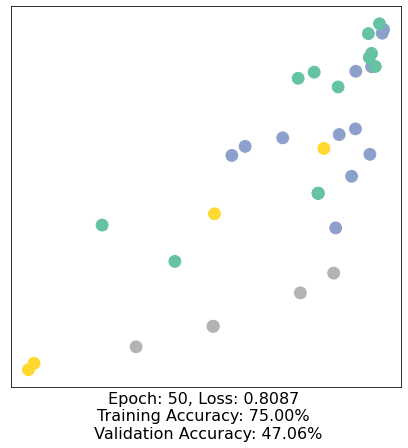

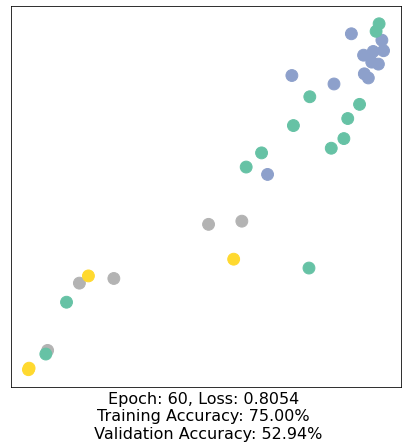

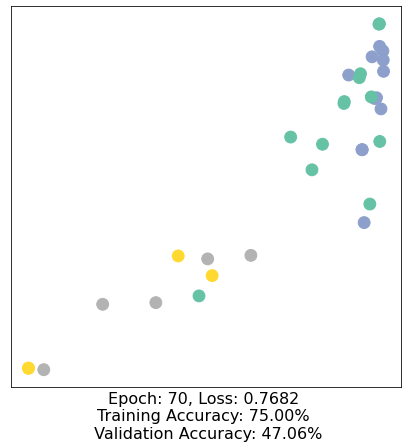

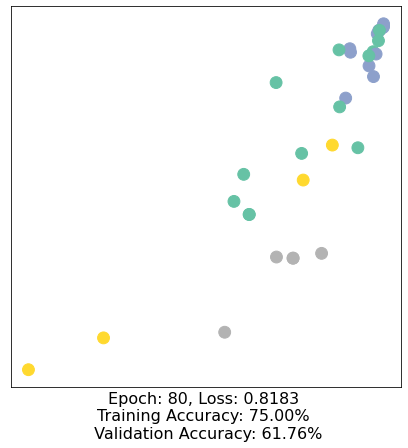

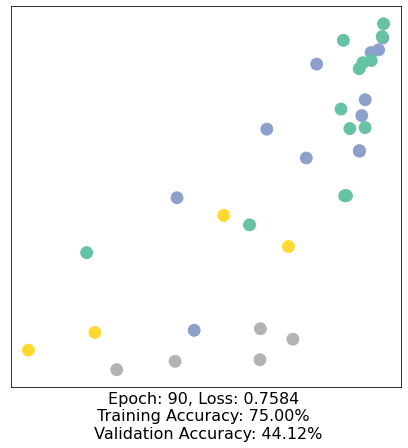

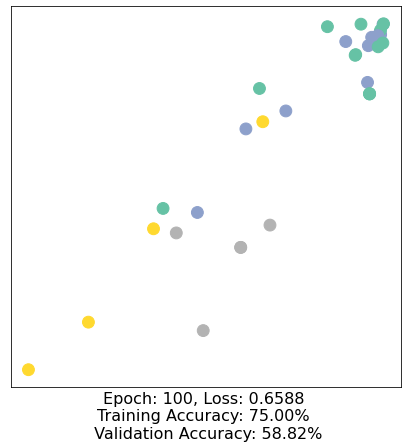

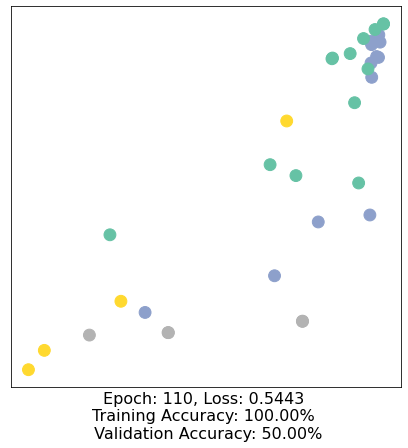

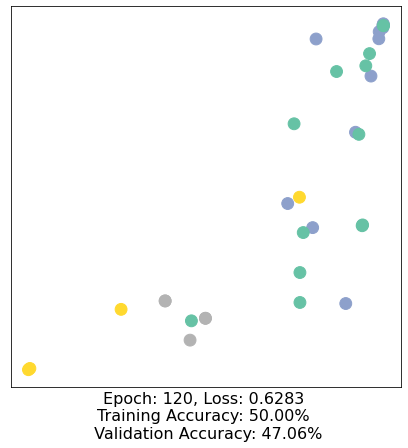

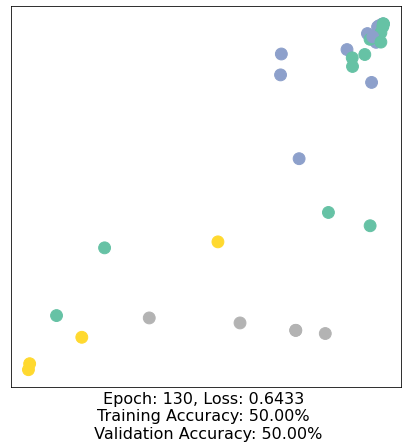

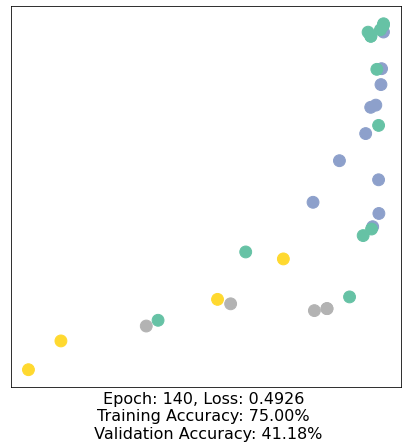

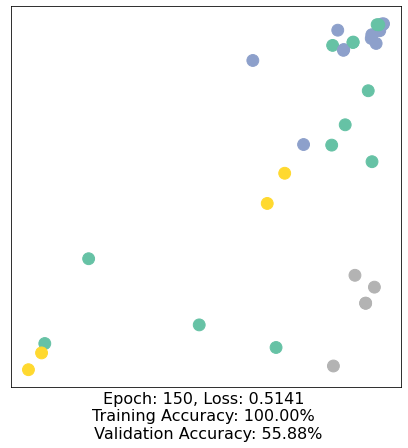

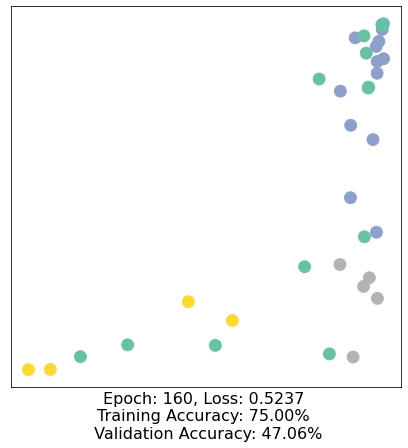

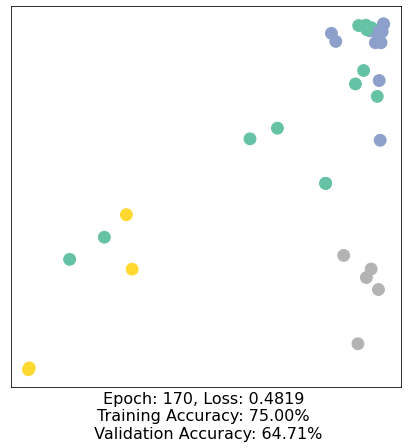

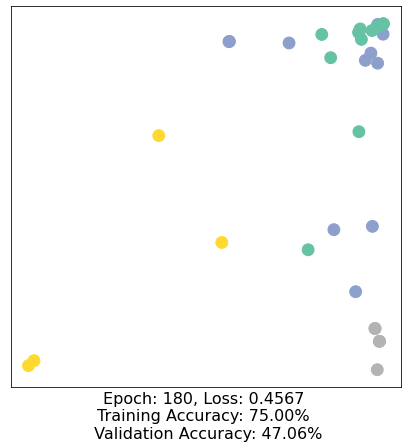

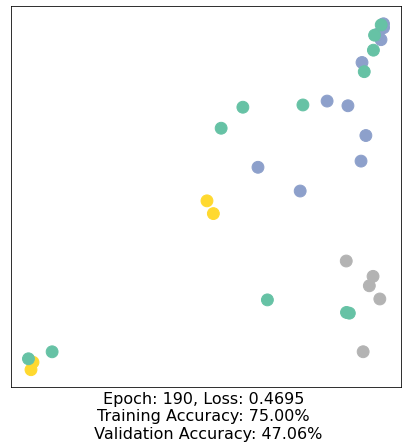

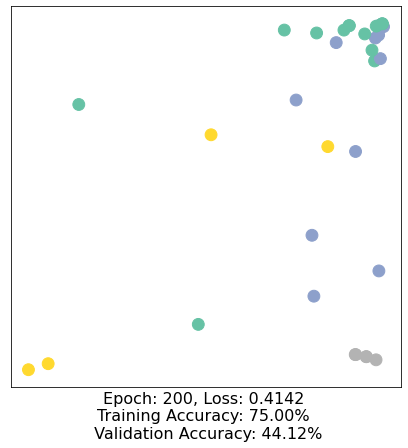

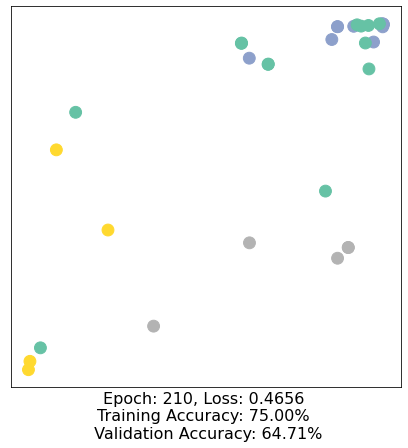

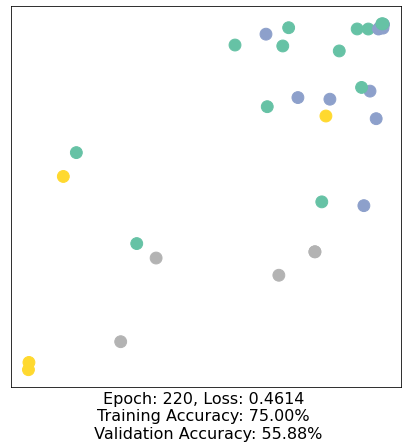

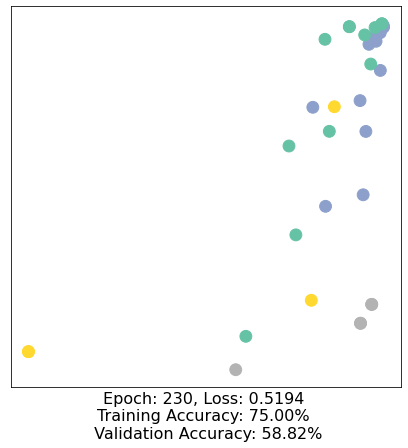

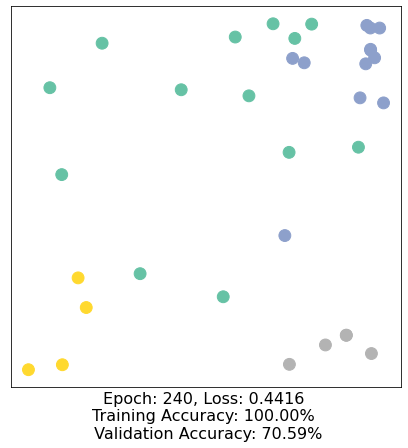

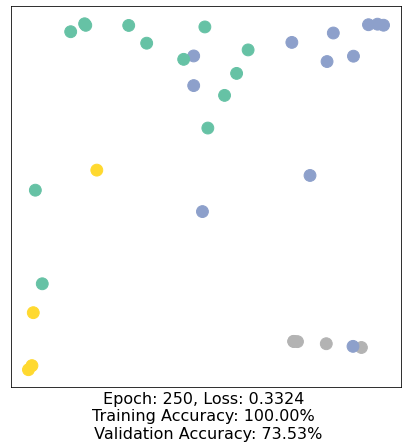

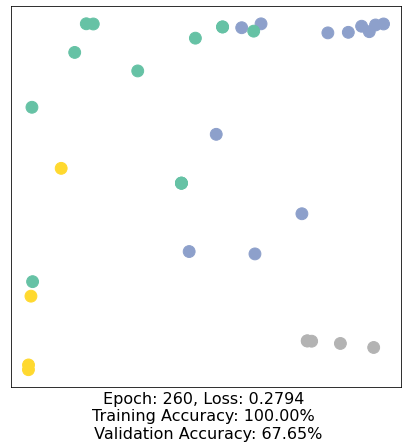

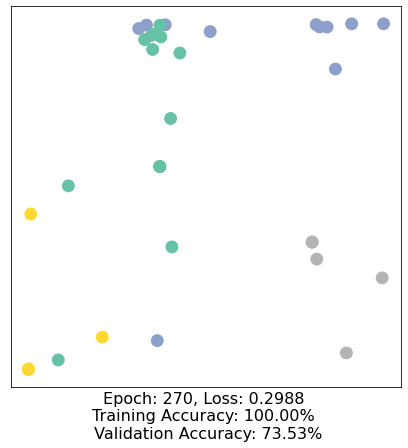

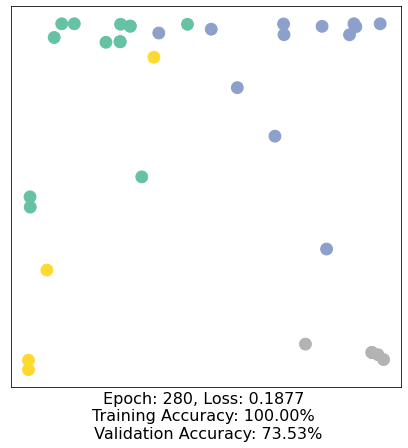

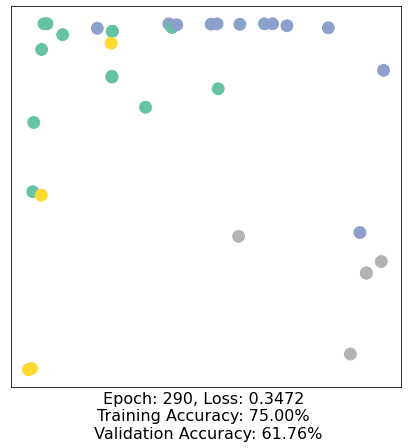

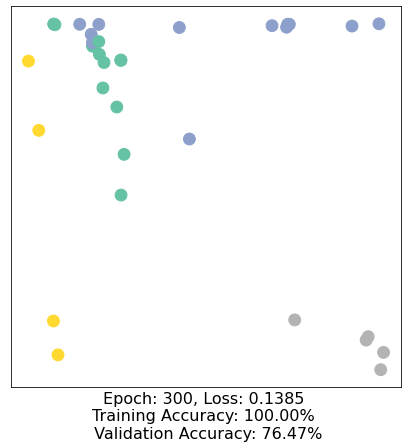

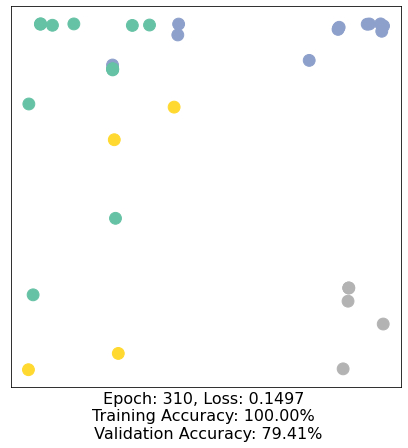

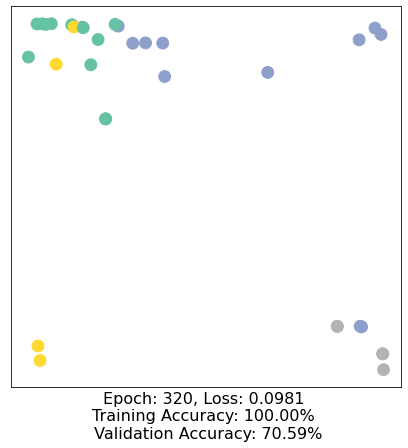

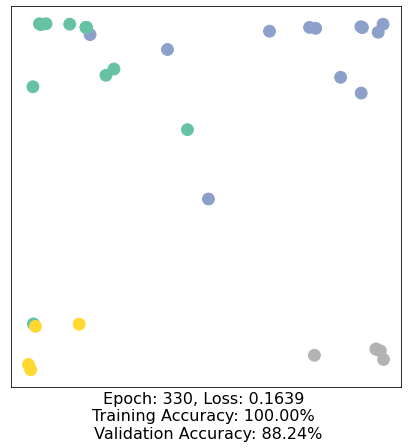

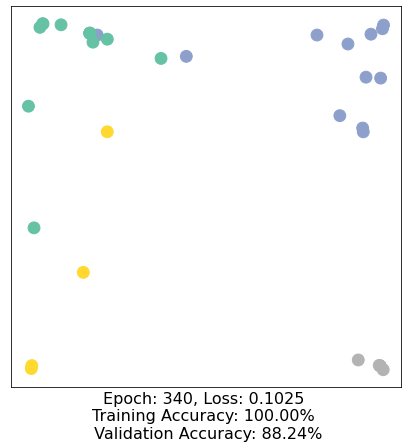

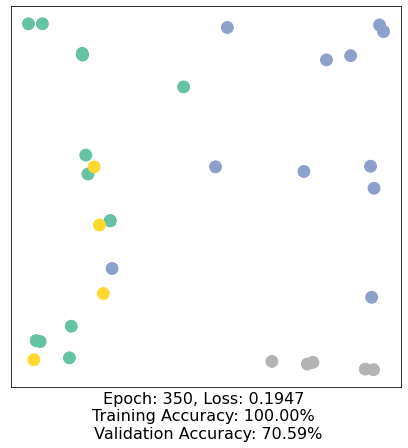

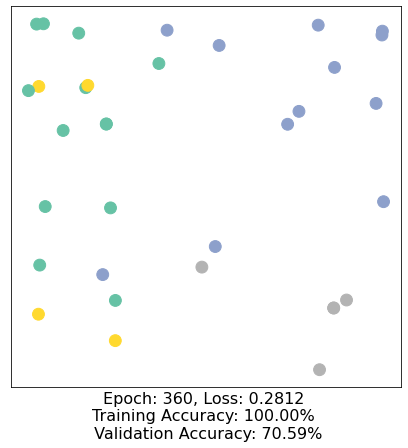

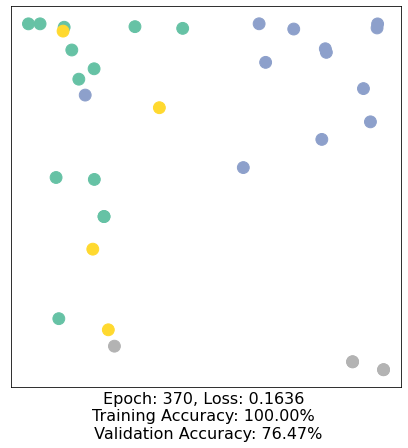

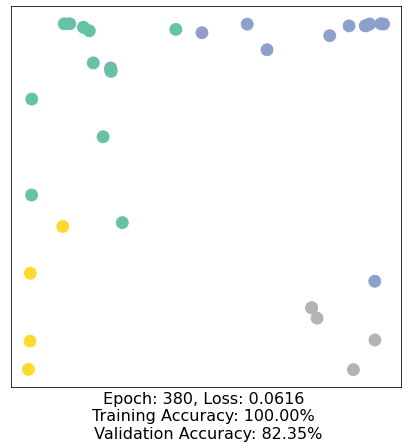

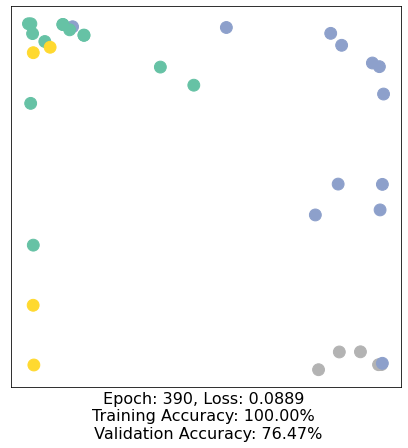

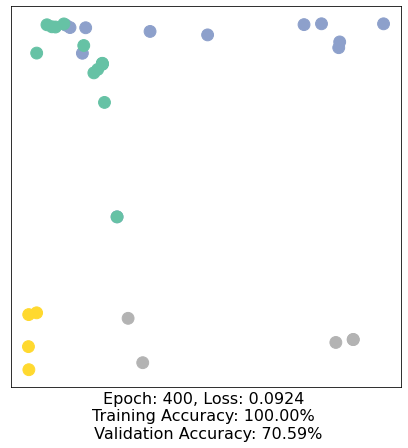

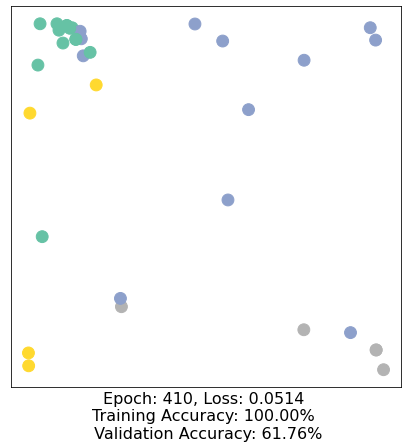

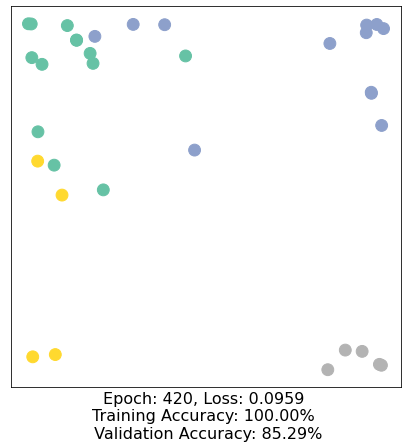

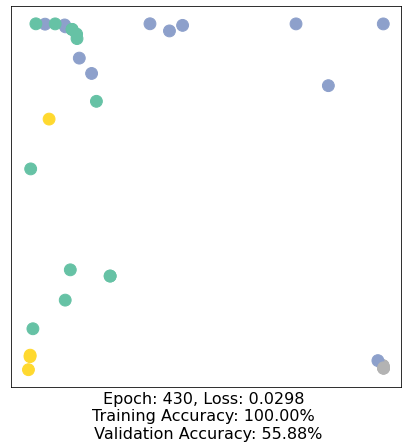

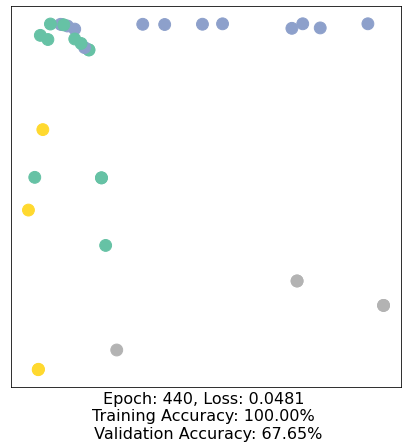

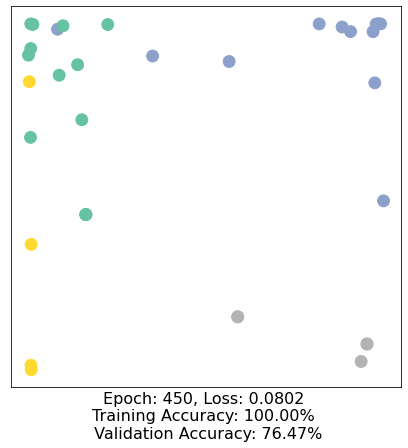

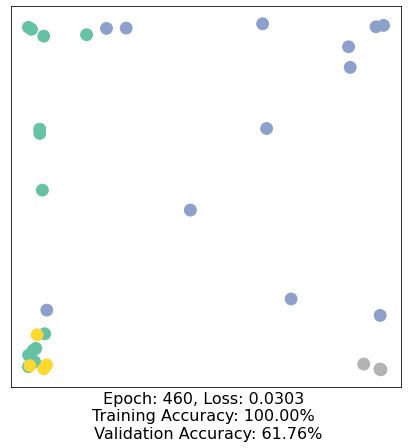

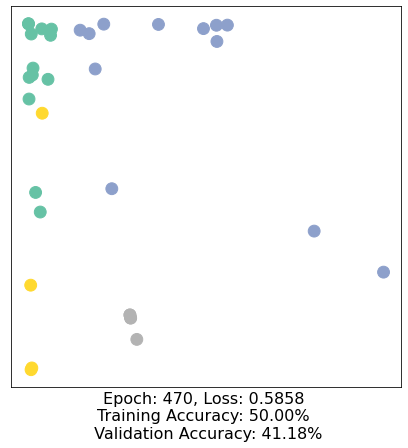

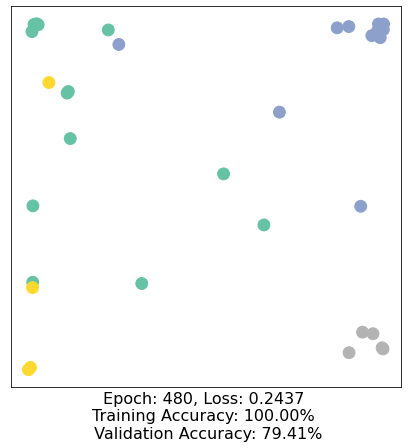

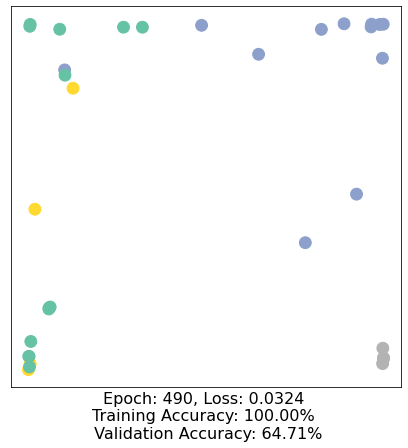

In [74]:
import time
from IPython.display import Javascript  # Restrict height of output cell.

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(500):
    loss, h, accuracy = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.3)